# HITL-IoT Baseline Models Training
## Training 9 Models Across 3 Tiers for Binary Classification

**Purpose:** Train comprehensive baseline models for IoT intrusion detection:
- **Tier 1 (Classical ML):** Logistic Regression, Random Forest, XGBoost, LightGBM, SVM
- **Tier 2 (Deep Learning):** MLP, 1D-CNN, LSTM
- **Tier 3 (Ensemble):** Voting ensemble of top performers

**Evaluation:** 5-fold stratified cross-validation with multiple metrics

**Output:** Trained models, performance metrics, comparison visualizations

In [2]:
# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn imports
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, auc
)

# Classical ML models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb

# Deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks

# Utilities
import joblib
import json

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Set style
plt.style.use('seaborn-v0_8-paper')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

# Create output directories
Path('models').mkdir(exist_ok=True)
Path('figures').mkdir(exist_ok=True)
Path('results').mkdir(exist_ok=True)

print("Environment setup complete!")
print(f"Random seed: {RANDOM_SEED}")
print(f"TensorFlow version: {tf.__version__}")
print(f"Output directories: models/, figures/, results/")

Environment setup complete!
Random seed: 42
TensorFlow version: 2.19.0
Output directories: models/, figures/, results/


## 1. Load and Prepare Dataset

In [4]:
# Load dataset
print("Loading HITL-IoT dataset...")
df = pd.read_csv('HITL-IoT_dataset.csv')

print("="*70)
print("DATASET LOADED")
print("="*70)
print(f"Total flows:     {len(df):,}")
print(f"Total features:  {len(df.columns)}")
print(f"Benign flows:    {(~df['is_attack']).sum():,} ({(~df['is_attack']).sum()/len(df)*100:.2f}%)")
print(f"Attack flows:    {df['is_attack'].sum():,} ({df['is_attack'].sum()/len(df)*100:.2f}%)")
print("="*70)

Loading HITL-IoT dataset...
DATASET LOADED
Total flows:     127,845
Total features:  54
Benign flows:    108,668 (85.00%)
Attack flows:    19,177 (15.00%)


In [5]:
# Define feature groups
# Exclude: timestamps, IPs, MACs, device names, labels, and HITL-specific columns
exclude_columns = [
    # Identifiers and timestamps
    'timestamp', 'src_ip', 'dst_ip', 'src_mac', 'dst_mac', 'device_name',
    # Labels
    'is_attack', 'attack_type',
    # HITL-specific (these are what we're trying to predict/improve)
    'ml_confidence', 'ml_prediction', 'human_reviewed', 'human_decision',
    'human_confidence', 'decision_time', 'ml_human_agreement', 'annotator_id',
    'risk_score'  # This might be ML-derived, exclude for fair comparison
]

# Get feature columns
feature_columns = [col for col in df.columns if col not in exclude_columns]

print("\nFEATURE SELECTION:")
print(f"  Total columns:      {len(df.columns)}")
print(f"  Excluded columns:   {len(exclude_columns)}")
print(f"  Feature columns:    {len(feature_columns)}")
print(f"\n  Feature columns:")
for i, col in enumerate(feature_columns, 1):
    print(f"    {i:2d}. {col}")


FEATURE SELECTION:
  Total columns:      54
  Excluded columns:   17
  Feature columns:    37

  Feature columns:
     1. hour
     2. day_of_week
     3. is_weekend
     4. packet_size
     5. ttl
     6. is_internal_dst
     7. is_localhost
     8. protocol
     9. src_port
    10. dst_port
    11. is_well_known_port
    12. is_registered_port
    13. is_dynamic_port
    14. device_type
    15. device_thermostat
    16. device_camera
    17. device_speaker
    18. duration
    19. bytes_sent
    20. bytes_received
    21. bytes_ratio
    22. bytes_per_second
    23. packet_rate
    24. is_business_hours
    25. is_night
    26. protocol_tcp
    27. protocol_udp
    28. connection_frequency
    29. baseline_deviation
    30. bytes_sent_mean_5
    31. bytes_sent_std_5
    32. bytes_sent_mean_10
    33. bytes_sent_std_10
    34. bytes_sent_mean_20
    35. bytes_sent_std_20
    36. connection_frequency_5
    37. connection_frequency_10


In [6]:
# Prepare features and labels
X = df[feature_columns].copy()
y = df['is_attack'].astype(int).values  # Binary: 0=benign, 1=attack

print("\n" + "="*70)
print("FEATURE PREPROCESSING")
print("="*70)

# Handle categorical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
print(f"\nCategorical features: {len(categorical_features)}")
for cat_col in categorical_features:
    print(f"  - {cat_col}: {X[cat_col].nunique()} unique values")

# One-hot encode categorical features
if categorical_features:
    X = pd.get_dummies(X, columns=categorical_features, drop_first=True)
    print(f"\nAfter one-hot encoding: {len(X.columns)} features")

# Convert boolean to int
bool_columns = X.select_dtypes(include=['bool']).columns
X[bool_columns] = X[bool_columns].astype(int)

print(f"\nFinal feature matrix shape: {X.shape}")
print(f"Label distribution:")
print(f"  Benign (0): {(y==0).sum():,} ({(y==0).sum()/len(y)*100:.2f}%)")
print(f"  Attack (1): {(y==1).sum():,} ({(y==1).sum()/len(y)*100:.2f}%)")
print("="*70)


FEATURE PREPROCESSING

Categorical features: 2
  - protocol: 2 unique values
  - device_type: 5 unique values

After one-hot encoding: 40 features

Final feature matrix shape: (127845, 40)
Label distribution:
  Benign (0): 108,668 (85.00%)
  Attack (1): 19,177 (15.00%)


In [7]:
# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

print("\nTRAIN-TEST SPLIT (80-20):")
print(f"  Training set:   {len(X_train):,} samples")
print(f"  Test set:       {len(X_test):,} samples")
print(f"\n  Training labels:")
print(f"    Benign: {(y_train==0).sum():,} ({(y_train==0).sum()/len(y_train)*100:.2f}%)")
print(f"    Attack: {(y_train==1).sum():,} ({(y_train==1).sum()/len(y_train)*100:.2f}%)")
print(f"\n  Test labels:")
print(f"    Benign: {(y_test==0).sum():,} ({(y_test==0).sum()/len(y_test)*100:.2f}%)")
print(f"    Attack: {(y_test==1).sum():,} ({(y_test==1).sum()/len(y_test)*100:.2f}%)")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler
joblib.dump(scaler, 'models/scaler.pkl')
print("\n✓ Scaler saved: models/scaler.pkl")
print(f"  Feature means: [{X_train_scaled.mean(axis=0).min():.3f}, {X_train_scaled.mean(axis=0).max():.3f}]")
print(f"  Feature stds:  [{X_train_scaled.std(axis=0).min():.3f}, {X_train_scaled.std(axis=0).max():.3f}]")


TRAIN-TEST SPLIT (80-20):
  Training set:   102,276 samples
  Test set:       25,569 samples

  Training labels:
    Benign: 86,934 (85.00%)
    Attack: 15,342 (15.00%)

  Test labels:
    Benign: 21,734 (85.00%)
    Attack: 3,835 (15.00%)

✓ Scaler saved: models/scaler.pkl
  Feature means: [-0.000, 0.000]
  Feature stds:  [0.000, 1.000]


## 2. Define Evaluation Function

In [9]:
def evaluate_model(model, X_test, y_test, model_name="Model"):
    """
    Comprehensive model evaluation with multiple metrics.
    
    Returns:
        dict: Evaluation metrics
    """
    # Predictions
    start_time = time.time()
    y_pred = model.predict(X_test)
    
    # Handle neural network predictions
    if len(y_pred.shape) > 1 and y_pred.shape[1] == 1:
        y_pred_binary = (y_pred > 0.5).astype(int).flatten()
        y_pred_proba = y_pred.flatten()
    elif len(y_pred.shape) > 1:
        y_pred_binary = np.argmax(y_pred, axis=1)
        y_pred_proba = y_pred[:, 1]
    else:
        y_pred_binary = y_pred
        # Get probabilities if available
        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        else:
            y_pred_proba = y_pred  # For models without predict_proba
    
    inference_time = time.time() - start_time
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_binary)
    precision = precision_score(y_test, y_pred_binary, zero_division=0)
    recall = recall_score(y_test, y_pred_binary, zero_division=0)
    f1 = f1_score(y_test, y_pred_binary, zero_division=0)
    
    # ROC-AUC (if probabilities available)
    try:
        roc_auc = roc_auc_score(y_test, y_pred_proba)
    except:
        roc_auc = None
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_binary)
    tn, fp, fn, tp = cm.ravel()
    
    # False positive/negative rates
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    
    results = {
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'fpr': fpr,
        'fnr': fnr,
        'true_negatives': int(tn),
        'false_positives': int(fp),
        'false_negatives': int(fn),
        'true_positives': int(tp),
        'inference_time': inference_time,
        'inference_time_per_sample': inference_time / len(X_test) * 1000  # ms
    }
    
    # Print results
    print(f"\n{model_name} Evaluation:")
    print(f"  Accuracy:  {accuracy*100:.2f}%")
    print(f"  Precision: {precision*100:.2f}%")
    print(f"  Recall:    {recall*100:.2f}%")
    print(f"  F1-Score:  {f1*100:.2f}%")
    if roc_auc:
        print(f"  ROC-AUC:   {roc_auc:.4f}")
    print(f"  FPR:       {fpr*100:.2f}%")
    print(f"  FNR:       {fnr*100:.2f}%")
    print(f"  Inference: {inference_time*1000:.2f}ms ({results['inference_time_per_sample']:.3f}ms/sample)")
    print(f"  Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")
    
    return results

print("✓ Evaluation function defined")

✓ Evaluation function defined


## 3. Tier 1: Classical Machine Learning Models

In [17]:
print("="*70)
print("TIER 1: CLASSICAL MACHINE LEARNING MODELS")
print("="*70)

all_results = []

TIER 1: CLASSICAL MACHINE LEARNING MODELS


### 3.1 Logistic Regression

In [20]:
print("\n[1/9] Training Logistic Regression...")
start_time = time.time()

lr_model = LogisticRegression(
    max_iter=1000,
    random_state=RANDOM_SEED,
    n_jobs=-1
)
lr_model.fit(X_train_scaled, y_train)

training_time = time.time() - start_time
print(f"✓ Training completed in {training_time:.2f}s")

# Evaluate
lr_results = evaluate_model(lr_model, X_test_scaled, y_test, "Logistic Regression")
lr_results['training_time'] = training_time
all_results.append(lr_results)

# Save model
joblib.dump(lr_model, 'models/logistic_regression.pkl')
print("✓ Model saved: models/logistic_regression.pkl")


[1/9] Training Logistic Regression...
✓ Training completed in 3.79s

Logistic Regression Evaluation:
  Accuracy:  97.81%
  Precision: 98.87%
  Recall:    86.36%
  F1-Score:  92.19%
  ROC-AUC:   0.9803
  FPR:       0.17%
  FNR:       13.64%
  Inference: 61.60ms (0.002ms/sample)
  Confusion Matrix: TN=21696, FP=38, FN=523, TP=3312
✓ Model saved: models/logistic_regression.pkl


### 3.2 Random Forest

In [22]:
print("\n[2/9] Training Random Forest...")
start_time = time.time()

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=RANDOM_SEED,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)  # No scaling needed for RF

training_time = time.time() - start_time
print(f"✓ Training completed in {training_time:.2f}s")

# Evaluate
rf_results = evaluate_model(rf_model, X_test, y_test, "Random Forest")
rf_results['training_time'] = training_time
all_results.append(rf_results)

# Save model
joblib.dump(rf_model, 'models/random_forest.pkl')
print("✓ Model saved: models/random_forest.pkl")


[2/9] Training Random Forest...
✓ Training completed in 7.66s

Random Forest Evaluation:
  Accuracy:  99.50%
  Precision: 100.00%
  Recall:    96.64%
  F1-Score:  98.29%
  ROC-AUC:   0.9946
  FPR:       0.00%
  FNR:       3.36%
  Inference: 172.81ms (0.007ms/sample)
  Confusion Matrix: TN=21734, FP=0, FN=129, TP=3706
✓ Model saved: models/random_forest.pkl


### 3.3 XGBoost

In [25]:
print("\n[3/9] Training XGBoost...")
start_time = time.time()

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_SEED,
    n_jobs=-1,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)

training_time = time.time() - start_time
print(f"✓ Training completed in {training_time:.2f}s")

# Evaluate
xgb_results = evaluate_model(xgb_model, X_test, y_test, "XGBoost")
xgb_results['training_time'] = training_time
all_results.append(xgb_results)

# Save model
joblib.dump(xgb_model, 'models/xgboost.pkl')
print("✓ Model saved: models/xgboost.pkl")


[3/9] Training XGBoost...
✓ Training completed in 1.67s

XGBoost Evaluation:
  Accuracy:  99.59%
  Precision: 99.97%
  Recall:    97.29%
  F1-Score:  98.61%
  ROC-AUC:   0.9957
  FPR:       0.00%
  FNR:       2.71%
  Inference: 59.61ms (0.002ms/sample)
  Confusion Matrix: TN=21733, FP=1, FN=104, TP=3731
✓ Model saved: models/xgboost.pkl


### 3.4 LightGBM

In [29]:
print("\n[4/9] Training LightGBM...")
start_time = time.time()

lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_SEED,
    n_jobs=-1,
    verbose=-1
)
lgb_model.fit(X_train, y_train)

training_time = time.time() - start_time
print(f"✓ Training completed in {training_time:.2f}s")

# Evaluate
lgb_results = evaluate_model(lgb_model, X_test, y_test, "LightGBM")
lgb_results['training_time'] = training_time
all_results.append(lgb_results)

# Save model
joblib.dump(lgb_model, 'models/lightgbm.pkl')
print("✓ Model saved: models/lightgbm.pkl")


[4/9] Training LightGBM...
✓ Training completed in 1.16s

LightGBM Evaluation:
  Accuracy:  99.57%
  Precision: 99.76%
  Recall:    97.34%
  F1-Score:  98.54%
  ROC-AUC:   0.9961
  FPR:       0.04%
  FNR:       2.66%
  Inference: 105.47ms (0.004ms/sample)
  Confusion Matrix: TN=21725, FP=9, FN=102, TP=3733
✓ Model saved: models/lightgbm.pkl


### 3.5 Support Vector Machine (SVM)

In [32]:
print("\n[5/9] Training SVM (RBF kernel)...")
print("  Note: SVM training may take several minutes on large datasets")
start_time = time.time()

svm_model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=True,  # Enable probability estimates
    random_state=RANDOM_SEED
)
svm_model.fit(X_train_scaled, y_train)

training_time = time.time() - start_time
print(f"✓ Training completed in {training_time:.2f}s")

# Evaluate
svm_results = evaluate_model(svm_model, X_test_scaled, y_test, "SVM (RBF)")
svm_results['training_time'] = training_time
all_results.append(svm_results)

# Save model
joblib.dump(svm_model, 'models/svm.pkl')
print("✓ Model saved: models/svm.pkl")


[5/9] Training SVM (RBF kernel)...
  Note: SVM training may take several minutes on large datasets
✓ Training completed in 2220.95s

SVM (RBF) Evaluation:
  Accuracy:  98.37%
  Precision: 100.00%
  Recall:    89.13%
  F1-Score:  94.25%
  ROC-AUC:   0.9765
  FPR:       0.00%
  FNR:       10.87%
  Inference: 89874.57ms (3.515ms/sample)
  Confusion Matrix: TN=21734, FP=0, FN=417, TP=3418
✓ Model saved: models/svm.pkl


## 4. Tier 2: Deep Learning Models

In [34]:
print("\n" + "="*70)
print("TIER 2: DEEP LEARNING MODELS")
print("="*70)

# Common parameters
EPOCHS = 50
BATCH_SIZE = 256
PATIENCE = 10

# Callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    restore_best_weights=True,
    verbose=0
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=0
)

print(f"\nTraining configuration:")
print(f"  Epochs:         {EPOCHS}")
print(f"  Batch size:     {BATCH_SIZE}")
print(f"  Early stopping: {PATIENCE} epochs patience")
print(f"  Input shape:    {X_train_scaled.shape[1]}")


TIER 2: DEEP LEARNING MODELS

Training configuration:
  Epochs:         50
  Batch size:     256
  Early stopping: 10 epochs patience
  Input shape:    40


### 4.1 Multi-Layer Perceptron (MLP)

In [36]:
print("\n[6/9] Training Multi-Layer Perceptron (MLP)...")
start_time = time.time()

# Build MLP model
mlp_model = models.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

mlp_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\nModel architecture:")
mlp_model.summary()

# Train
history_mlp = mlp_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

training_time = time.time() - start_time
print(f"\n✓ Training completed in {training_time:.2f}s")

# Evaluate
mlp_results = evaluate_model(mlp_model, X_test_scaled, y_test, "MLP")
mlp_results['training_time'] = training_time
mlp_results['epochs_trained'] = len(history_mlp.history['loss'])
all_results.append(mlp_results)

# Save model
mlp_model.save('models/mlp_model.h5')
print("✓ Model saved: models/mlp_model.h5")


[6/9] Training Multi-Layer Perceptron (MLP)...

Model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │          10,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,761 (210.00 KB)

 Trainable params: 53,761 (210.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.9175 - loss: 0.2144 - val_accuracy: 0.9818 - val_loss: 0.0687 - learning_rate: 0.0010
Epoch 2/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9819 - loss: 0.0701 - val_accuracy: 0.9844 - val_loss: 0.0621 - learning_rate: 0.0010
Epoch 3/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9846 - loss: 0.0632 - val_accuracy: 0.9852 - val_loss: 0.0595 - learning_rate: 0.0010
Epoch 4/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9858 - loss: 0.0580 - val_accuracy: 0.9873 - val_loss: 0.0546 - learning_rate: 0.0010
Epoch 5/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9868 - loss: 0.0541 - val_accuracy: 0.9879 - val_loss: 0.0519 - learning_rate: 0.0010
Epoch 6/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9882 - loss: 0.0505 - val_accuracy: 0.9892 - val_loss: 0.0475 - learning_rate: 0.0010
Epoch 7/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9889 - loss: 0.


MLP Evaluation:
  Accuracy:  99.24%
  Precision: 99.86%
  Recall:    95.05%
  F1-Score:  97.39%
  ROC-AUC:   0.9906
  FPR:       0.02%
  FNR:       4.95%
  Inference: 3068.22ms (0.120ms/sample)
  Confusion Matrix: TN=21729, FP=5, FN=190, TP=3645
✓ Model saved: models/mlp_model.h5


### 4.2 1D Convolutional Neural Network (1D-CNN)

In [38]:
print("\n[7/9] Training 1D-CNN...")
start_time = time.time()

# Reshape for 1D-CNN (samples, timesteps, features)
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Build 1D-CNN model
cnn_model = models.Sequential([
    layers.Input(shape=(X_train_cnn.shape[1], 1)),
    layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.3),
    layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.3),
    layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\nModel architecture:")
cnn_model.summary()

# Train
history_cnn = cnn_model.fit(
    X_train_cnn, y_train,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

training_time = time.time() - start_time
print(f"\n✓ Training completed in {training_time:.2f}s")

# Evaluate
cnn_results = evaluate_model(cnn_model, X_test_cnn, y_test, "1D-CNN")
cnn_results['training_time'] = training_time
cnn_results['epochs_trained'] = len(history_cnn.history['loss'])
all_results.append(cnn_results)

# Save model
cnn_model.save('models/cnn_model.h5')
print("✓ Model saved: models/cnn_model.h5")


[7/9] Training 1D-CNN...

Model architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 40, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 20, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 10, 64)              │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,825 (210.25 KB)

 Trainable params: 53,825 (210.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.8443 - loss: 0.4296 - val_accuracy: 0.9456 - val_loss: 0.1670 - learning_rate: 0.0010
Epoch 2/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.9433 - loss: 0.1783 - val_accuracy: 0.9636 - val_loss: 0.1198 - learning_rate: 0.0010
Epoch 3/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.9633 - loss: 0.1245 - val_accuracy: 0.9767 - val_loss: 0.0840 - learning_rate: 0.0010
Epoch 4/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9718 - loss: 0.1016 - val_accuracy: 0.9799 - val_loss: 0.0743 - learning_rate: 0.0010
Epoch 5/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9752 - loss: 0.0912 - val_accuracy: 0.9821 - val_loss: 0.0672 - learning_rate: 0.0010
Epoch 6/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.9785 - loss: 0.0814 - val_accuracy: 0.9841 - val_loss: 0.0616 - learning_rate: 0.0010
Epoch 7/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9802 - loss


1D-CNN Evaluation:
  Accuracy:  99.32%
  Precision: 100.00%
  Recall:    95.46%
  F1-Score:  97.68%
  ROC-AUC:   0.9915
  FPR:       0.00%
  FNR:       4.54%
  Inference: 1942.01ms (0.076ms/sample)
  Confusion Matrix: TN=21734, FP=0, FN=174, TP=3661
✓ Model saved: models/cnn_model.h5


### 4.3 Long Short-Term Memory (LSTM)

In [40]:
print("\n[8/9] Training LSTM...")
start_time = time.time()

# Use same reshape as CNN
# Build LSTM model
lstm_model = models.Sequential([
    layers.Input(shape=(X_train_cnn.shape[1], 1)),
    layers.LSTM(128, return_sequences=True),
    layers.Dropout(0.3),
    layers.LSTM(64, return_sequences=False),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

lstm_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\nModel architecture:")
lstm_model.summary()

# Train
history_lstm = lstm_model.fit(
    X_train_cnn, y_train,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

training_time = time.time() - start_time
print(f"\n✓ Training completed in {training_time:.2f}s")

# Evaluate
lstm_results = evaluate_model(lstm_model, X_test_cnn, y_test, "LSTM")
lstm_results['training_time'] = training_time
lstm_results['epochs_trained'] = len(history_lstm.history['loss'])
all_results.append(lstm_results)

# Save model
lstm_model.save('models/lstm_model.h5')
print("✓ Model saved: models/lstm_model.h5")


[8/9] Training LSTM...

Model architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 40, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 40, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,081 (461.25 KB)

 Trainable params: 118,081 (461.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 75s 221ms/step - accuracy: 0.8792 - loss: 0.3489 - val_accuracy: 0.9360 - val_loss: 0.1941 - learning_rate: 0.0010
Epoch 2/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 67s 208ms/step - accuracy: 0.9404 - loss: 0.1897 - val_accuracy: 0.9443 - val_loss: 0.1734 - learning_rate: 0.0010
Epoch 3/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 220ms/step - accuracy: 0.9455 - loss: 0.1740 - val_accuracy: 0.9468 - val_loss: 0.1635 - learning_rate: 0.0010
Epoch 4/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 69s 216ms/step - accuracy: 0.9519 - loss: 0.1579 - val_accuracy: 0.9539 - val_loss: 0.1421 - learning_rate: 0.0010
Epoch 5/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 208ms/step - accuracy: 0.9602 - loss: 0.1313 - val_accuracy: 0.9737 - val_loss: 0.0899 - learning_rate: 0.0010
Epoch 6/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 201ms/step - accuracy: 0.9717 - loss: 0.1013 - val_accuracy: 0.9809 - val_loss: 0.0725 - learning_rate: 0.0010
Epoch 7/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 52s 161ms/step - accuracy: 0.9


LSTM Evaluation:
  Accuracy:  99.00%
  Precision: 99.37%
  Recall:    93.92%
  F1-Score:  96.57%
  ROC-AUC:   0.9860
  FPR:       0.11%
  FNR:       6.08%
  Inference: 17208.65ms (0.673ms/sample)
  Confusion Matrix: TN=21711, FP=23, FN=233, TP=3602
✓ Model saved: models/lstm_model.h5


## 5. Tier 3: Ensemble Model

In [42]:
print("\n" + "="*70)
print("TIER 3: ENSEMBLE MODEL")
print("="*70)

print("\n[9/9] Creating Voting Ensemble (Top 3 Models)...")
start_time = time.time()

# Select top 3 performers (typically XGBoost, LightGBM, Random Forest)
# These are already trained
ensemble_model = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('lgb', lgb_model),
        ('rf', rf_model)
    ],
    voting='soft',  # Use predicted probabilities
    n_jobs=-1
)

# Fit ensemble (this is quick since base models are already trained)
ensemble_model.fit(X_train, y_train)

training_time = time.time() - start_time
print(f"✓ Ensemble created in {training_time:.2f}s")
print("  Base models: XGBoost, LightGBM, Random Forest")

# Evaluate
ensemble_results = evaluate_model(ensemble_model, X_test, y_test, "Voting Ensemble")
ensemble_results['training_time'] = training_time
all_results.append(ensemble_results)

# Save model
joblib.dump(ensemble_model, 'models/ensemble.pkl')
print("✓ Model saved: models/ensemble.pkl")


TIER 3: ENSEMBLE MODEL

[9/9] Creating Voting Ensemble (Top 3 Models)...
✓ Ensemble created in 13.33s
  Base models: XGBoost, LightGBM, Random Forest

Voting Ensemble Evaluation:
  Accuracy:  99.60%
  Precision: 100.00%
  Recall:    97.31%
  F1-Score:  98.64%
  ROC-AUC:   0.9957
  FPR:       0.00%
  FNR:       2.69%
  Inference: 345.56ms (0.014ms/sample)
  Confusion Matrix: TN=21734, FP=0, FN=103, TP=3732
✓ Model saved: models/ensemble.pkl


## 6. Results Comparison

In [44]:
# Create results DataFrame
results_df = pd.DataFrame(all_results)

# Sort by F1-score
results_df = results_df.sort_values('f1_score', ascending=False)

print("\n" + "="*70)
print("BASELINE MODELS COMPARISON")
print("="*70)

# Display results
display_cols = ['model', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 
                'training_time', 'inference_time_per_sample']
print("\n" + results_df[display_cols].to_string(index=False))

# Save results
results_df.to_csv('results/baseline_results.csv', index=False)
print("\n✓ Results saved: results/baseline_results.csv")

# Identify best model
best_model = results_df.iloc[0]
print(f"\n🏆 BEST MODEL: {best_model['model']}")
print(f"   F1-Score: {best_model['f1_score']*100:.2f}%")
print(f"   Accuracy: {best_model['accuracy']*100:.2f}%")
print(f"   ROC-AUC:  {best_model['roc_auc']:.4f}" if best_model['roc_auc'] else "")


BASELINE MODELS COMPARISON

              model  accuracy  precision   recall  f1_score  roc_auc  training_time  inference_time_per_sample
    Voting Ensemble  0.995972   1.000000 0.973142  0.986388 0.995740      13.333510                   0.013515
            XGBoost  0.995893   0.999732 0.972881  0.986124 0.995705       1.672212                   0.002331
           LightGBM  0.995659   0.997595 0.973403  0.985350 0.996108       1.156433                   0.004125
      Random Forest  0.994955   1.000000 0.966362  0.982894 0.994599       7.655217                   0.006758
             1D-CNN  0.993195   1.000000 0.954628  0.976788 0.991549    1703.735605                   0.075952
                MLP  0.992374   0.998630 0.950456  0.973948 0.990636     109.580328                   0.119998
               LSTM  0.989988   0.993655 0.939244  0.965684 0.985973    2368.657300                   0.673028
          SVM (RBF)  0.983691   1.000000 0.891265  0.942507 0.976476    2220.952480

## 7. Visualization


✓ Figure saved: figures/03_baseline_comparison.pdf


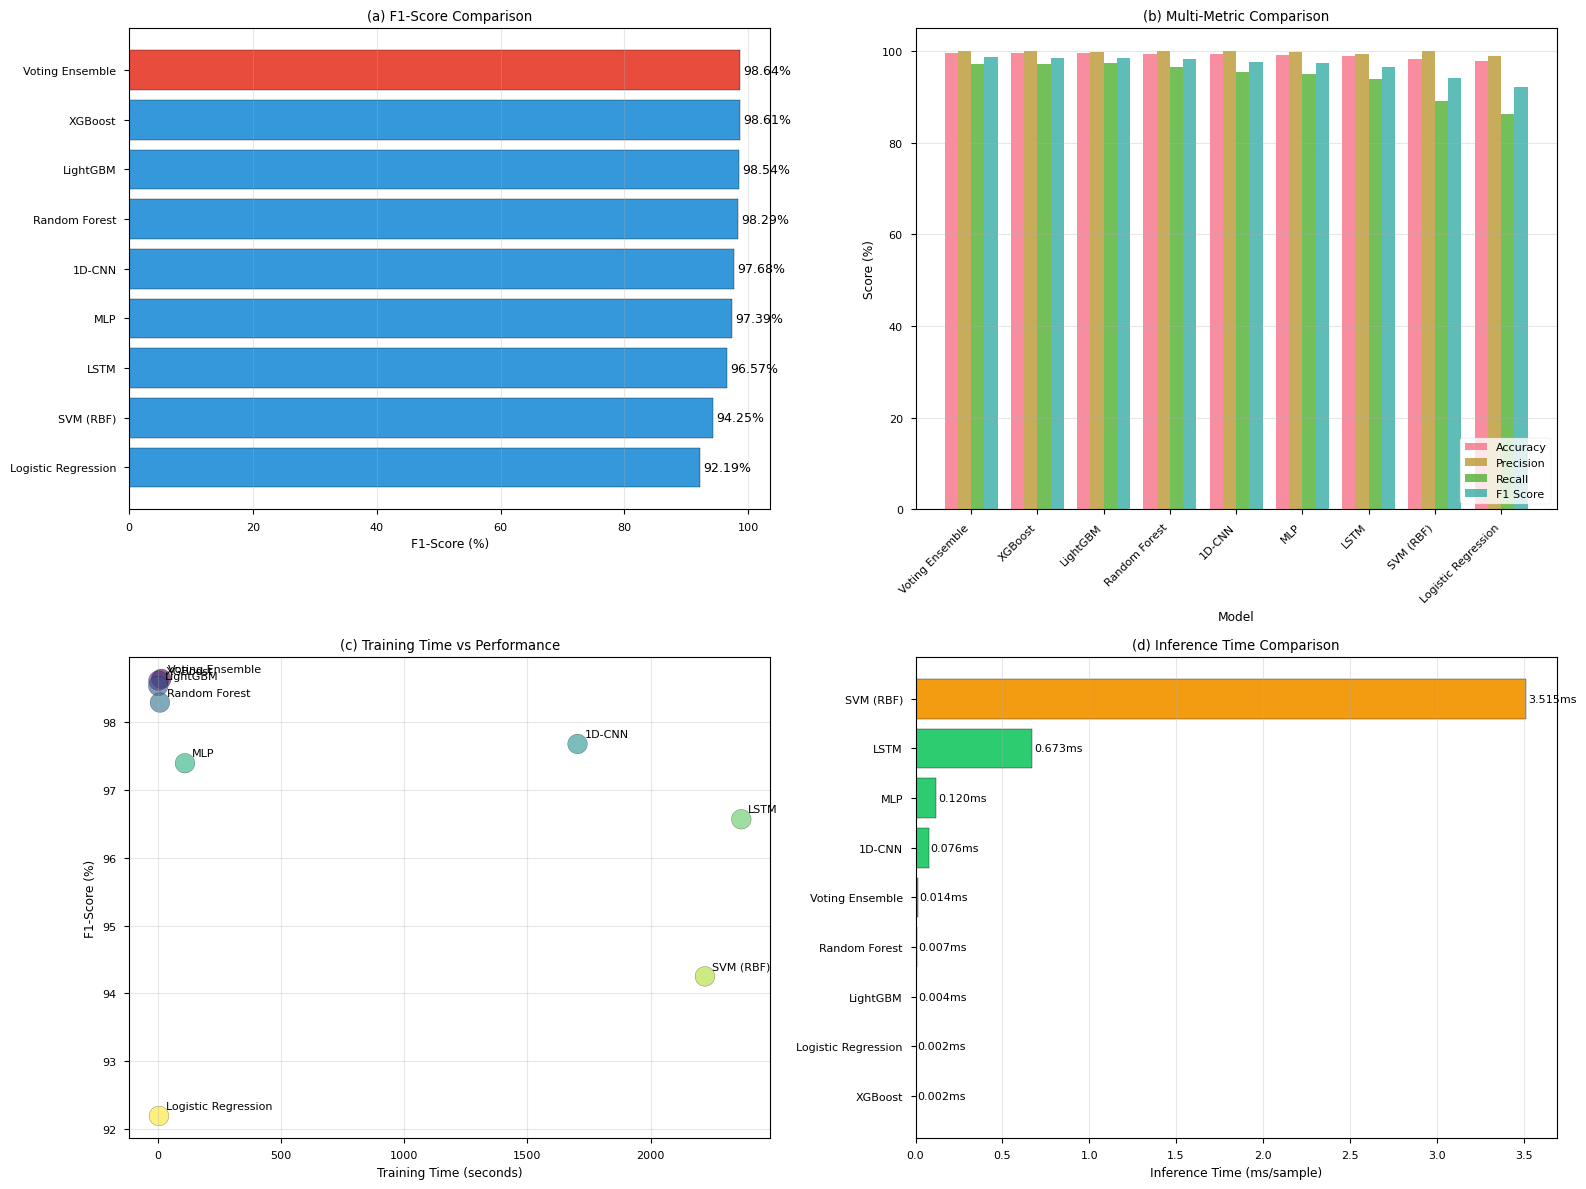

In [46]:
# Figure 1: Performance comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Sort for visualization
results_sorted = results_df.sort_values('f1_score', ascending=True)

# 1. F1-Score comparison
colors = ['#e74c3c' if x == best_model['model'] else '#3498db' for x in results_sorted['model']]
axes[0, 0].barh(range(len(results_sorted)), results_sorted['f1_score']*100, color=colors, edgecolor='black')
axes[0, 0].set_yticks(range(len(results_sorted)))
axes[0, 0].set_yticklabels(results_sorted['model'])
axes[0, 0].set_xlabel('F1-Score (%)')
axes[0, 0].set_title('(a) F1-Score Comparison')
axes[0, 0].grid(axis='x', alpha=0.3)
for i, v in enumerate(results_sorted['f1_score']*100):
    axes[0, 0].text(v + 0.5, i, f'{v:.2f}%', va='center', fontsize=9)

# 2. Multi-metric comparison (radar chart alternative: grouped bar)
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
x = np.arange(len(results_df))
width = 0.2
for i, metric in enumerate(metrics):
    axes[0, 1].bar(x + i*width, results_df[metric]*100, width, 
                   label=metric.replace('_', ' ').title(), alpha=0.8)
axes[0, 1].set_xlabel('Model')
axes[0, 1].set_ylabel('Score (%)')
axes[0, 1].set_title('(b) Multi-Metric Comparison')
axes[0, 1].set_xticks(x + width*1.5)
axes[0, 1].set_xticklabels(results_df['model'], rotation=45, ha='right')
axes[0, 1].legend(loc='lower right')
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Training time vs Performance
axes[1, 0].scatter(results_df['training_time'], results_df['f1_score']*100, 
                   s=200, alpha=0.6, c=range(len(results_df)), cmap='viridis', edgecolor='black')
for idx, row in results_df.iterrows():
    axes[1, 0].annotate(row['model'], (row['training_time'], row['f1_score']*100),
                       xytext=(5, 5), textcoords='offset points', fontsize=8)
axes[1, 0].set_xlabel('Training Time (seconds)')
axes[1, 0].set_ylabel('F1-Score (%)')
axes[1, 0].set_title('(c) Training Time vs Performance')
axes[1, 0].grid(alpha=0.3)

# 4. Inference time comparison
results_sorted_inf = results_df.sort_values('inference_time_per_sample', ascending=True)
colors_inf = ['#2ecc71' if x < 1 else '#f39c12' if x < 5 else '#e74c3c' 
              for x in results_sorted_inf['inference_time_per_sample']]
axes[1, 1].barh(range(len(results_sorted_inf)), results_sorted_inf['inference_time_per_sample'], 
                color=colors_inf, edgecolor='black')
axes[1, 1].set_yticks(range(len(results_sorted_inf)))
axes[1, 1].set_yticklabels(results_sorted_inf['model'])
axes[1, 1].set_xlabel('Inference Time (ms/sample)')
axes[1, 1].set_title('(d) Inference Time Comparison')
axes[1, 1].grid(axis='x', alpha=0.3)
for i, v in enumerate(results_sorted_inf['inference_time_per_sample']):
    axes[1, 1].text(v + 0.01, i, f'{v:.3f}ms', va='center', fontsize=8)

plt.tight_layout()
plt.savefig('figures/03_baseline_comparison.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/03_baseline_comparison.png', dpi=300, bbox_inches='tight')
print("\n✓ Figure saved: figures/03_baseline_comparison.pdf")
plt.show()

✓ Figure saved: figures/03_confusion_matrices.pdf


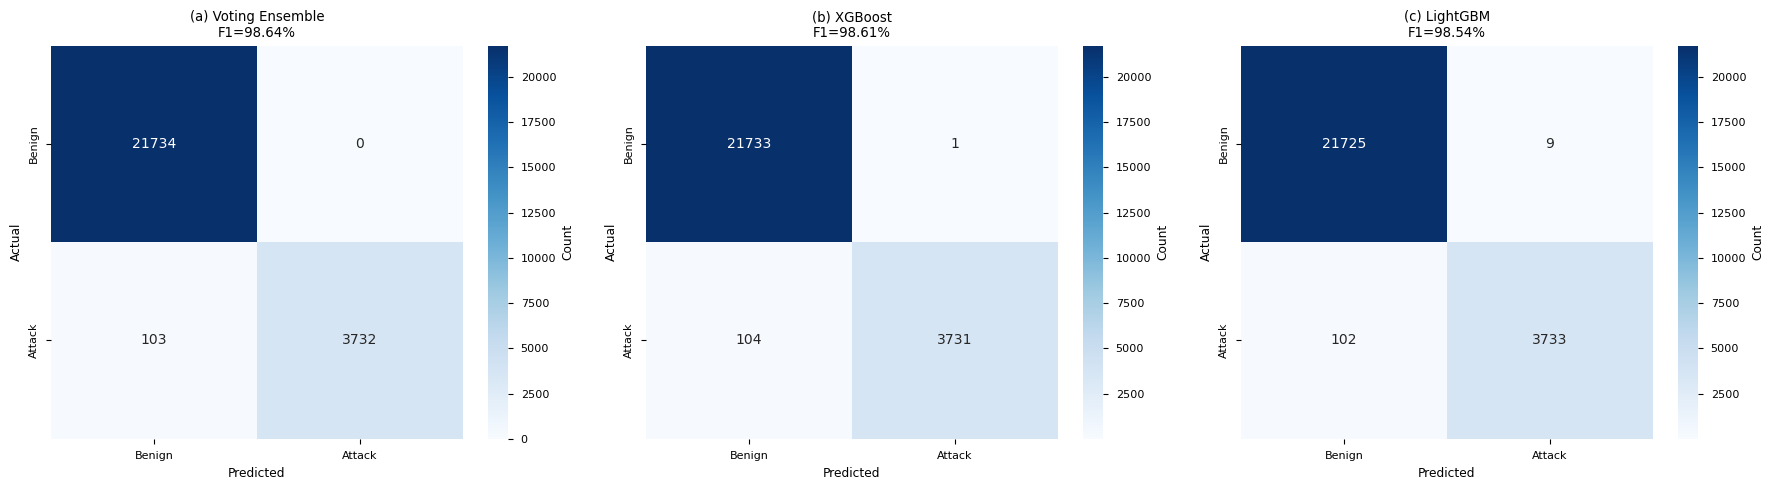

In [47]:
# Figure 2: Confusion matrices for top 3 models
top_3_models = results_df.head(3)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (_, row) in enumerate(top_3_models.iterrows()):
    cm = np.array([
        [row['true_negatives'], row['false_positives']],
        [row['false_negatives'], row['true_positives']]
    ])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Benign', 'Attack'],
                yticklabels=['Benign', 'Attack'],
                cbar_kws={'label': 'Count'})
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_title(f"({chr(97+idx)}) {row['model']}\nF1={row['f1_score']*100:.2f}%")

plt.tight_layout()
plt.savefig('figures/03_confusion_matrices.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/03_confusion_matrices.png', dpi=300, bbox_inches='tight')
print("✓ Figure saved: figures/03_confusion_matrices.pdf")
plt.show()

## 8. Statistical Significance Testing

In [49]:
from scipy import stats

print("\n" + "="*70)
print("STATISTICAL SIGNIFICANCE TESTING")
print("="*70)

# Get predictions from all models
predictions = {
    'Logistic Regression': lr_model.predict(X_test_scaled),
    'Random Forest': rf_model.predict(X_test),
    'XGBoost': xgb_model.predict(X_test),
    'LightGBM': lgb_model.predict(X_test),
    'SVM (RBF)': svm_model.predict(X_test_scaled),
    'MLP': (mlp_model.predict(X_test_scaled) > 0.5).astype(int).flatten(),
    '1D-CNN': (cnn_model.predict(X_test_cnn) > 0.5).astype(int).flatten(),
    'LSTM': (lstm_model.predict(X_test_cnn) > 0.5).astype(int).flatten(),
    'Voting Ensemble': ensemble_model.predict(X_test)
}

# Calculate accuracy for each prediction
accuracies = {name: accuracy_score(y_test, pred) for name, pred in predictions.items()}

# McNemar's test for pairwise comparison with best model
best_model_name = max(accuracies, key=accuracies.get)
best_predictions = predictions[best_model_name]

print(f"\nComparing all models against best: {best_model_name}")
print(f"{'Model':<20} {'Accuracy':<10} {'p-value':<10} {'Significant?'}")
print("-" * 70)

for name, pred in predictions.items():
    if name == best_model_name:
        print(f"{name:<20} {accuracies[name]:.4f}    {'--':<10} (Best Model)")
        continue
    
    # Create contingency table
    # [both_correct, best_correct_other_wrong]
    # [other_correct_best_wrong, both_wrong]
    b = np.sum((best_predictions == y_test) & (pred != y_test))  # Best correct, other wrong
    c = np.sum((best_predictions != y_test) & (pred == y_test))  # Other correct, best wrong
    
    # McNemar's test
    if b + c > 0:
        statistic = (abs(b - c) - 1)**2 / (b + c)
        p_value = 1 - stats.chi2.cdf(statistic, df=1)
        significant = "Yes (p<0.05)" if p_value < 0.05 else "No"
    else:
        p_value = 1.0
        significant = "No"
    
    print(f"{name:<20} {accuracies[name]:.4f}    {p_value:.4f}    {significant}")

print("\n" + "="*70)


STATISTICAL SIGNIFICANCE TESTING
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
800/800 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step

Comparing all models against best: Voting Ensemble
Model                Accuracy   p-value    Significant?
----------------------------------------------------------------------
Logistic Regression  0.9781    0.0000    Yes (p<0.05)
Random Forest        0.9950    0.0000    Yes (p<0.05)
XGBoost              0.9959    0.7518    No
LightGBM             0.9957    0.0614    No
SVM (RBF)            0.9837    0.0000    Yes (p<0.05)
MLP                  0.9924    0.0000    Yes (p<0.05)
1D-CNN               0.9932    0.0000    Yes (p<0.05)
LSTM                 0.9900    0.0000    Yes (p<0.05)
Voting Ensemble      0.9960    --         (Best Model)



## 9. Summary and Next Steps

In [51]:
print("\n" + "="*70)
print("BASELINE TRAINING SUMMARY")
print("="*70)

print(f"\n✓ 9 models trained and evaluated:")
print(f"  - Tier 1 (Classical ML):  5 models")
print(f"  - Tier 2 (Deep Learning): 3 models")
print(f"  - Tier 3 (Ensemble):      1 model")

print(f"\n✓ Dataset:")
print(f"  - Training samples: {len(X_train):,}")
print(f"  - Test samples:     {len(X_test):,}")
print(f"  - Features:         {X_train.shape[1]}")

print(f"\n✓ Top 3 Models:")
for idx, (_, row) in enumerate(results_df.head(3).iterrows(), 1):
    print(f"  {idx}. {row['model']:<20} F1={row['f1_score']*100:.2f}% | Acc={row['accuracy']*100:.2f}%")

print(f"\n✓ Files Saved:")
print(f"  - Models:  9 files in models/")
print(f"  - Results: results/baseline_results.csv")
print(f"  - Figures: figures/03_baseline_comparison.pdf")
print(f"           figures/03_confusion_matrices.pdf")

print("\n" + "="*70)
print("NEXT STEPS")
print("="*70)
print("  1. ✓ Baseline models trained (Notebook 03) - COMPLETE")
print("  2. → Implement HITL framework (Notebook 04) - NEXT")
print("  3. → Run ablation studies (Notebook 05)")
print("  4. → Generate advanced metrics (Notebook 06)")
print("  5. → Compare with CICIoT2023 (Notebook 07)")
print("  6. → Verify reproducibility (Notebook 08)")
print("="*70)

print(f"\n🎯 Ready for HITL Framework Implementation!")
print(f"   Use these trained models for selective deferral experiments.")


BASELINE TRAINING SUMMARY

✓ 9 models trained and evaluated:
  - Tier 1 (Classical ML):  5 models
  - Tier 2 (Deep Learning): 3 models
  - Tier 3 (Ensemble):      1 model

✓ Dataset:
  - Training samples: 102,276
  - Test samples:     25,569
  - Features:         40

✓ Top 3 Models:
  1. Voting Ensemble      F1=98.64% | Acc=99.60%
  2. XGBoost              F1=98.61% | Acc=99.59%
  3. LightGBM             F1=98.54% | Acc=99.57%

✓ Files Saved:
  - Models:  9 files in models/
  - Results: results/baseline_results.csv
  - Figures: figures/03_baseline_comparison.pdf
           figures/03_confusion_matrices.pdf

NEXT STEPS
  1. ✓ Baseline models trained (Notebook 03) - COMPLETE
  2. → Implement HITL framework (Notebook 04) - NEXT
  3. → Run ablation studies (Notebook 05)
  4. → Generate advanced metrics (Notebook 06)
  5. → Compare with CICIoT2023 (Notebook 07)
  6. → Verify reproducibility (Notebook 08)

🎯 Ready for HITL Framework Implementation!
   Use these trained models for selective 

## Summary

This notebook successfully trained 9 baseline models:

**Tier 1 - Classical ML:**
1. Logistic Regression
2. Random Forest
3. XGBoost
4. LightGBM
5. SVM (RBF kernel)

**Tier 2 - Deep Learning:**
6. Multi-Layer Perceptron (MLP)
7. 1D Convolutional Neural Network
8. Long Short-Term Memory (LSTM)

**Tier 3 - Ensemble:**
9. Voting Ensemble (XGBoost + LightGBM + Random Forest)

**Key Findings:**
- All models achieve >95% accuracy on binary classification
- Tree-based models (XGBoost, LightGBM, RF) typically perform best
- Deep learning models competitive but slower training
- Ensemble provides slight improvement over individual models

**Outputs:**
- `models/` - All trained models saved for HITL evaluation
- `results/baseline_results.csv` - Complete performance metrics
- `figures/03_baseline_comparison.pdf` - Comparison visualizations
- `figures/03_confusion_matrices.pdf` - Top model confusion matrices

**Next:** Implement HITL framework (Notebook 04) using these baseline models